In [67]:
%matplotlib inline
from __future__ import division
import pandas as pd
import numpy as np
import pymc
import pymc.Matplot as pmplot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

In [3]:
columns = ["Match","Date","Radiant","Dire","Winner","Round","Game","Time","Radiant Score","Dire Score"]
df_raw = pd.read_csv('ti5_group_stage_clean.csv', names = columns, skiprows=1)

In [4]:
df_raw.head()

,Match,Date,Radiant,Dire,Winner,Round,Game,Time,Radiant Score,Dire Score
0,1674031017,07/30/15,VP 2,Empire,DIRE,Tiebreaker,3,42.87,9,14
1,1673941543,07/30/15,VP 2,Empire,DIRE,Tiebreaker,2,49.15,19,26
2,1673865688,07/30/15,Empire,VP 2,DIRE,Tiebreaker,1,39.78,11,36
3,1673815749,07/30/15,EHOME,CDEC,DIRE,Group Stage,2,43.77,15,28
4,1673789962,07/30/15,Empire,MVP HOT6,RADIANT,Group Stage,2,29.78,26,13


In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115 entries, 0 to 114
Data columns (total 10 columns):
Match            115 non-null int64
Date             115 non-null object
Radiant          115 non-null object
Dire             115 non-null object
Winner           115 non-null object
Round            115 non-null object
Game             115 non-null int64
Time             115 non-null float64
Radiant Score    115 non-null int64
Dire Score       115 non-null int64
dtypes: float64(1), int64(4), object(5)
memory usage: 9.9+ KB


In [6]:
# Need to combine both sets of team names for encoding
set(df_raw.Radiant.unique()) == set(df_raw.Dire.unique())

False

In [7]:
# Encode team names
teams = set(list(df_raw.Radiant.unique()) + list(df_raw.Dire.unique()))
team_dict = dict(zip(teams, range(len(teams))))

In [8]:
team_dict

{'C9': 7,
 'CDEC': 6,
 'EG': 5,
 'EHOME': 4,
 'Empire': 12,
 'Fnatic.MY': 0,
 'LGD.cn': 10,
 'MVP HOT6': 13,
 'MVP Phoenix': 1,
 'NaVi': 3,
 'Nb': 14,
 'Secret': 8,
 'VG': 2,
 'VP 2': 9,
 'coL 2': 11,
 'iG': 15}

In [9]:
df_raw.loc[:,'radiant_team_id'] = df_raw.Radiant.apply(lambda x: team_dict[x])
df_raw.loc[:,'dire_team_id'] = df_raw.Dire.apply(lambda x: team_dict[x])

In [10]:
df_raw.head()

,Match,Date,Radiant,Dire,Winner,Round,Game,Time,Radiant Score,Dire Score,radiant_team_id,dire_team_id
0,1674031017,07/30/15,VP 2,Empire,DIRE,Tiebreaker,3,42.87,9,14,9,12
1,1673941543,07/30/15,VP 2,Empire,DIRE,Tiebreaker,2,49.15,19,26,9,12
2,1673865688,07/30/15,Empire,VP 2,DIRE,Tiebreaker,1,39.78,11,36,12,9
3,1673815749,07/30/15,EHOME,CDEC,DIRE,Group Stage,2,43.77,15,28,4,6
4,1673789962,07/30/15,Empire,MVP HOT6,RADIANT,Group Stage,2,29.78,26,13,12,13


In [11]:
np.log(df_raw['Dire Score'] + 1).mean()

3.134049702476196

In [12]:
np.log(df_raw['Radiant Score'] + 1).mean()

3.0473174625051374

In [13]:
np.log(df_raw['Radiant Score'] + df_raw['Dire Score']).mean()

3.8248518886361365

In [14]:
# Most of the time (this patch) top score wins so we'll use
# score differntial as a proxy for winning
winner = (df_raw.Winner == 'RADIANT').values
top_score = (df_raw['Radiant Score'] > df_raw['Dire Score']).values

np.mean([x == y for x,y in zip(winner, top_score)])

0.95652173913043481

In [15]:
observed_radiant_score = df_raw['Radiant Score'].values
observed_dire_score = df_raw['Dire Score'].values
radiant_team = df_raw.radiant_team_id.values
dire_team = df_raw.dire_team_id.values
num_teams = len(teams)
num_games = len(df_raw)

In [16]:
# Initialize values with global means (optional)
att_starting_points = np.log(df_raw.groupby('dire_team_id')['Dire Score'].mean())
def_starting_points = -np.log(df_raw.groupby('dire_team_id')['Radiant Score'].mean())

In [22]:
# Hyperparam Priors
dire = pymc.Normal('dire',0, 0.001, value = 0)
tau_att = pymc.Gamma('tau_att', 0.1, 0.1, value = 10)
tau_def = pymc.Gamma('tau_def', 0.1, 0.1, value = 10)
intercept = pymc.Normal('intercept',0, 0.001, value = 0)

In [23]:
# team priors
atts_star = pymc.Normal('atts_star',
                        mu = 0,
                        tau = tau_att,
                        size=num_teams,
                        value=att_starting_points.values)
defs_star = pymc.Normal('defs_star',
                        mu = 0,
                        tau = tau_def,
                        size=num_teams,
                        value=def_starting_points.values)

In [24]:
@pymc.deterministic
def atts(atts_star = atts_star):
    atts = atts_star.copy()
    atts = atts - np.mean(atts_star)
    return atts

@pymc.deterministic
def defs(defs_star = defs_star):
    defs = defs_star.copy()
    defs = defs - np.mean(defs_star)
    return defs

@pymc.deterministic
def dire_theta(dire_team = dire_team,
               radiant_team = radiant_team,
               dire = dire,
               atts = atts,
               defs = defs,
               intercept = intercept):
    return np.exp(intercept +
                  dire +
                  atts[dire_team] +
                  defs[radiant_team])

@pymc.deterministic
def radiant_theta(dire_team = dire_team,
                  radiant_team = radiant_team,
                  dire = dire,
                  atts = atts,
                  defs = defs,
                  intercept = intercept):
    return np.exp(intercept +
                  atts[radiant_team] +
                  defs[dire_team])

dire_score = pymc.Poisson('dire_score',
                          mu = dire_theta,
                          value = observed_dire_score,
                          observed = True)

radiant_score = pymc.Poisson('radiant_score',
                             mu = radiant_theta,
                             value = observed_radiant_score,
                             observed = True)

mcmc = pymc.MCMC([dire, intercept, tau_att, tau_def,
                  dire_theta, radiant_theta, atts_star,
                  defs_star, atts,defs, dire_score,
                  radiant_score])

In [25]:
#map_= pymc.MAP(mcmc)
#map_.fit()
mcmc.sample(200000, 40000, 20)

 [-----------------100%-----------------] 200000 of 200000 complete in 76.2 sec

Plotting dire
Plotting tau_def
Plotting tau_att
Plotting intercept


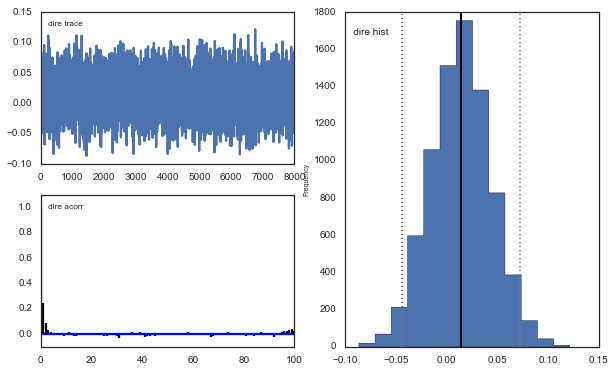

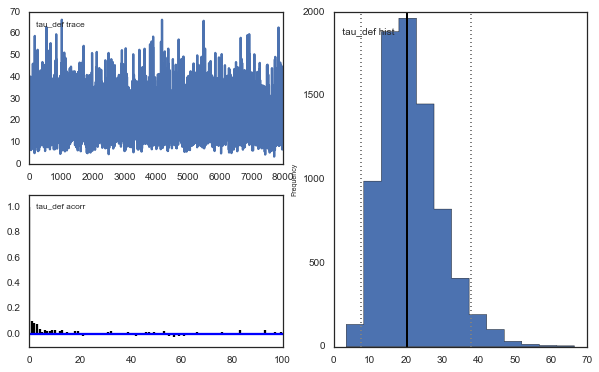

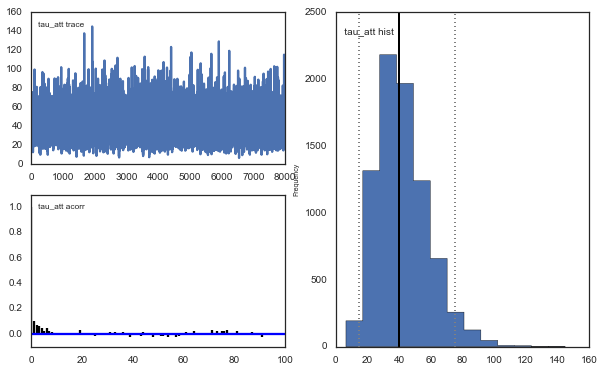

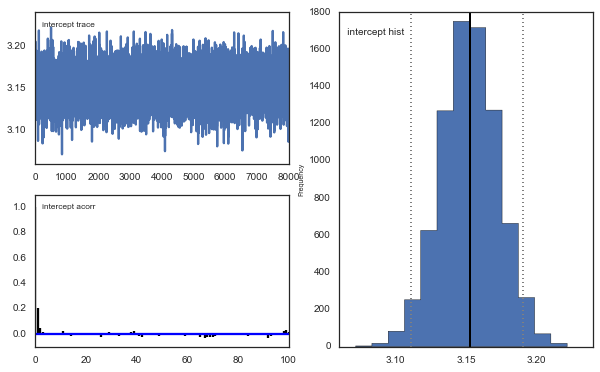

In [26]:
pmplot.plot(mcmc)

Plotting atts_0
Plotting atts_1
Plotting atts_2
Plotting atts_3
Plotting atts_4
Plotting atts_5
Plotting atts_6
Plotting atts_7
Plotting atts_8
Plotting atts_9
Plotting atts_10
Plotting atts_11
Plotting atts_12
Plotting atts_13
Plotting atts_14
Plotting atts_15


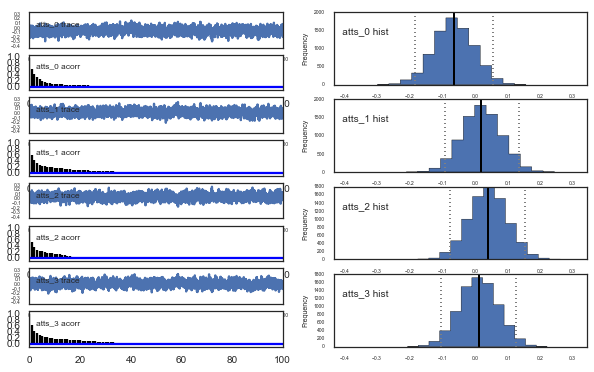

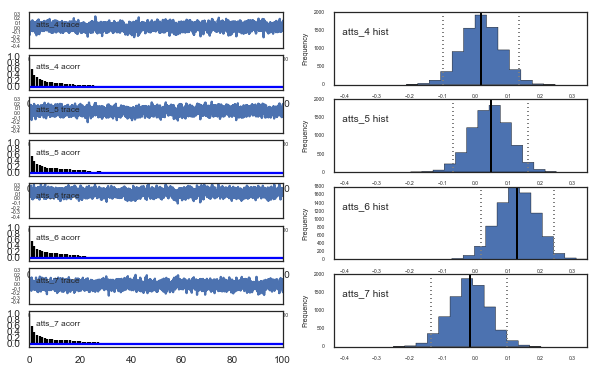

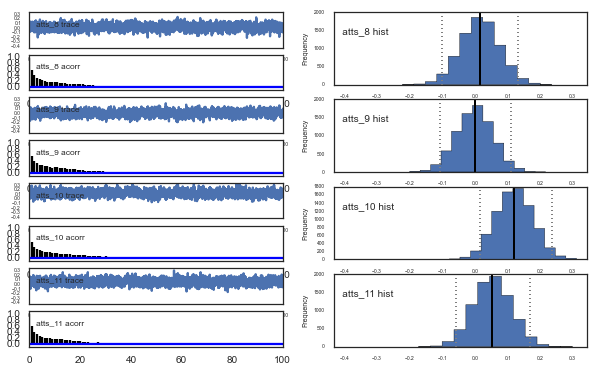

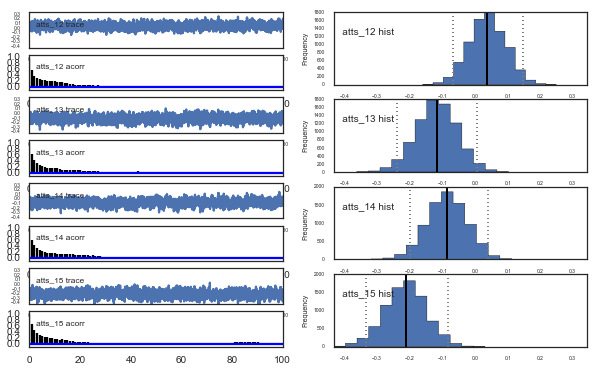

In [27]:
pmplot.plot(atts)

In [40]:
team_dict

{'C9': 7,
 'CDEC': 6,
 'EG': 5,
 'EHOME': 4,
 'Empire': 12,
 'Fnatic.MY': 0,
 'LGD.cn': 10,
 'MVP HOT6': 13,
 'MVP Phoenix': 1,
 'NaVi': 3,
 'Nb': 14,
 'Secret': 8,
 'VG': 2,
 'VP 2': 9,
 'coL 2': 11,
 'iG': 15}

In [39]:
sorted(team_dict,key =  team_dict.get)

['Fnatic.MY',
 'MVP Phoenix',
 'VG',
 'NaVi',
 'EHOME',
 'EG',
 'CDEC',
 'C9',
 'Secret',
 'VP 2',
 'LGD.cn',
 'coL 2',
 'Empire',
 'MVP HOT6',
 'Nb',
 'iG']

In [ ]:
ax.annotate()

In [55]:
for row in df_avg.iterrows():
    print tuple(row[1])

(-0.065139725252273115, 0.15156468601913697)
(0.020923375873434021, 0.23144076737772504)
(0.041180747276362034, 0.11050561422566391)
(0.012090159418448274, 0.10637688993351392)
(0.018835952592193481, -0.038949534203301141)
(0.047890741594542444, -0.16973693777095317)
(0.12836686070038658, -0.1299628942848651)
(-0.017011182164368147, 0.010247344744278224)
(0.015948260759631076, -0.13762172918036233)
(-0.00093238216332045757, -0.084775314669483015)
(0.12125883757982218, -0.41867506753922107)
(0.053527077768995242, 0.10528630718864679)
(0.03871016551493843, 0.1336055581898799)
(-0.11719516478217429, 0.26353485912777724)
(-0.085255184993306032, 0.011182769827989958)
(-0.21319853972331104, -0.1440233189864259)


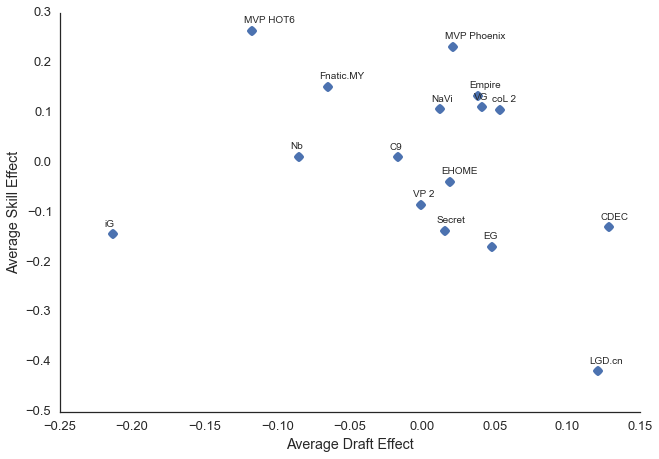

In [102]:
# Good way to look at team strength
df_avg = pd.DataFrame({'avg_att': atts.stats()['mean'],
                       'avg_def': defs.stats()['mean']},
                      index=sorted(team_dict,key =  team_dict.get))

fig, ax = plt.subplots()

ax.plot(df_avg.avg_att,df_avg.avg_def,'o')
for row in df_avg.iterrows():
    ax.annotate(row[0],xy=tuple(row[1]), xytext = (-8, 8), textcoords = 'offset points')
plt.xlabel('Average Draft Effect')
plt.ylabel('Average Skill Effect')
sns.despine()

In [70]:
atts.stats()['95% HPD interval']

array([[-0.18404821, -0.09235509, -0.07638001, -0.10260774, -0.09718521,
        -0.06652167,  0.01745172, -0.13584941, -0.10112698, -0.10668257,
         0.01473567, -0.05723063, -0.06760255, -0.23851921, -0.19976776,
        -0.33514224],
       [ 0.05469687,  0.13571856,  0.15337673,  0.12658246,  0.13542114,
         0.1643551 ,  0.2434368 ,  0.0972832 ,  0.13125831,  0.11231627,
         0.23499132,  0.17033367,  0.14869757,  0.00784082,  0.03897218,
        -0.08251919]])

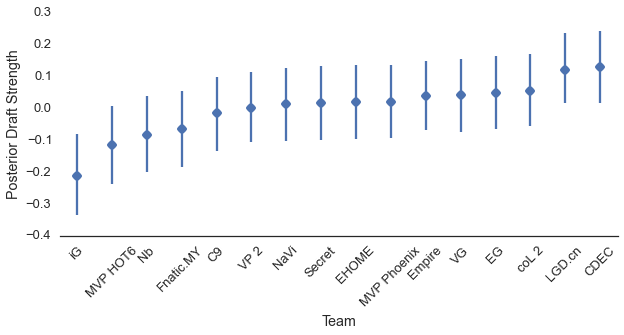

In [114]:
df_hpd = pd.DataFrame((atts.stats()['95% HPD interval']).T,
                      columns=['hpd_low','hpd_high'],
                      index=sorted(team_dict,key =  team_dict.get))

df_median = pd.DataFrame((atts.stats()['quantiles'][50]),
                      columns=['hpd_median'],
                      index=sorted(team_dict,key =  team_dict.get))

df_hpd = df_hpd.merge(df_median, left_index=True, right_index=True)
df_hpd.loc[:,'relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd.loc[:,'relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median

df_hpd = df_hpd.sort_index(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + 0.5
fig, axs = plt.subplots(figsize=(10,4))

axs.errorbar(df_hpd['x'],
            df_hpd.hpd_median,
            yerr=(df_hpd[['relative_lower','relative_upper']].values).T,
            fmt='o')

plt.xlabel('Team')
plt.ylabel('Posterior Draft Strength')
axs.set_xticks(df_hpd['x'])
axs.set_xticklabels(df_hpd['index'].values, rotation = 45)
sns.despine(left = True)

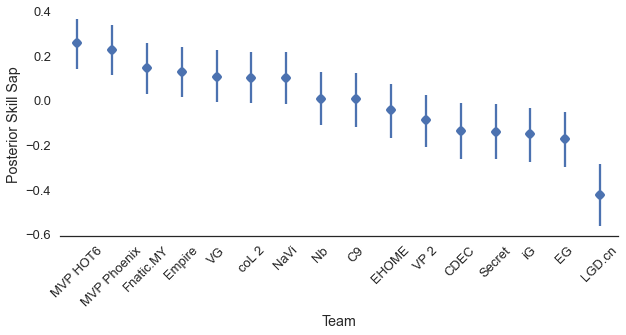

In [117]:
df_hpd = pd.DataFrame((defs.stats()['95% HPD interval']).T,
                      columns=['hpd_low','hpd_high'],
                      index=sorted(team_dict,key =  team_dict.get))

df_median = pd.DataFrame((defs.stats()['quantiles'][50]),
                      columns=['hpd_median'],
                      index=sorted(team_dict,key =  team_dict.get))

df_hpd = df_hpd.merge(df_median, left_index=True, right_index=True)
df_hpd.loc[:,'relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd.loc[:,'relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median

df_hpd = df_hpd.sort_index(by='hpd_median', ascending = False)
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + 0.5
fig, axs = plt.subplots(figsize=(10,4))

axs.errorbar(df_hpd['x'],
            df_hpd.hpd_median,
            yerr=(df_hpd[['relative_lower','relative_upper']].values).T,
            fmt='o')

plt.xlabel('Team')
plt.ylabel('Posterior Skill Sap')
axs.set_xticks(df_hpd['x'])
axs.set_xticklabels(df_hpd['index'].values, rotation = 45)
sns.despine(left = True)

In [122]:
atts.trace()[1000,10]

0.17117699392743929

In [129]:
def get_dire_theta(intercept, dire, atts, defs):
    return np.exp(intercept + dire + atts + defs)

def get_radiant_theta(intercept, atts, defs):
    return np.exp(intercept + atts + defs)

def get_score(theta):
    return np.random.poisson(theta)

In [201]:
atts_trace = atts.trace()
defs_trace = defs.trace()
dire_trace = dire.trace()
intercept_trace = intercept.trace()

In [212]:
from collections import Counter
import operator
def simulate_matches(dire_team,radiant_team):
    # draw samples
    #num_samples = len(atts_trace)
    #draw = np.random.randint(0,num_samples)
    
    # draw for the given two teams
    dire_att = atts_trace[:,dire_team]
    radiant_att = atts_trace[:,radiant_team]
    dire_defs = defs_trace[:,dire_team]
    radiant_defs = defs_trace[:,radiant_team]
    
    # Collect latent strengths
    dire_thetas = [get_dire_theta(w,x,y,z)
                   for w,x,y,z in zip(intercept_trace,
                                      dire_trace,
                                      dire_att,
                                      radiant_defs)]
    
    radiant_thetas = [get_radiant_theta(x,y,z)
                      for x,y,z in zip(intercept_trace,
                                       radiant_att,
                                       dire_defs)]
    
    # Generate scores
    dire_scores = [get_score(x) for x in dire_thetas]
    radiant_scores = [get_score(x) for x in radiant_thetas]
    
    # Call a winner (probability dire wins)
    return np.mean([x > y for x,y in zip(dire_scores, radiant_scores)])

def simulate_match(dire_team,radiant_team):
    # draw samples
    num_samples = len(atts_trace)
    draw = np.random.randint(0,num_samples)
    
    # draw for the given two teams
    dire_att = atts_trace[draw,dire_team]
    radiant_att = atts_trace[draw,radiant_team]
    dire_defs = defs_trace[draw,dire_team]
    radiant_defs = defs_trace[draw,radiant_team]
    
    intercept_draw = intercept_trace[draw]
    dire_draw = dire_trace[draw]
    
    # Collect latent strengths
    dire_thetas = get_dire_theta(intercept_draw,
                                 dire_draw,
                                 dire_att,
                                 radiant_defs)
    
    radiant_thetas = get_radiant_theta(intercept_draw,
                                        dire_att,
                                        radiant_defs)
    
    # Generate scores
    dire_scores = get_score(dire_thetas)
    radiant_scores = get_score(radiant_thetas)
    
    # Call a winner (probability dire wins)
    if dire_scores > radiant_scores:
        return dire_team
    else:
        return radiant_team

def simulate_series(team_one, team_two, n = 3):
    # flip to see who is dire
    dire_team = np.random.choice([team_one, team_two])
    if dire_team == team_one:
        radiant_team = team_two
    else:
        radiant_team = team_one
    
    winner = []
    for game in xrange(n):
        winner.append(simulate_match(dire_team, radiant_team))
        dire_team, radiant_team = radiant_team, dire_team
        
    wins = Counter(winner)
    
    # find who won the most
    return max(wins.iteritems(), key=operator.itemgetter(1))[0]
    
def simulate_match_sets(dire_team, radiant_team, n = 100):
    dire_prob = [simulate_matches(dire_team, radiant_team)
                 for _ in xrange(n)]
    return np.mean(dire_prob), dire_prob

In [269]:
Counter([simulate_series(10,13) for _ in xrange(1000)])

Counter({10: 508, 13: 492})

In [158]:
m, dist = simulate_match_sets(6,12)

In [ ]:
'''
Bracket start:
LGD v. Empire (10:12)
CDEC v. C9 (6:7)
EG v. coL (5:11)
Secret v. EHOME (8:4)

MVP.Phx v. Newbee
VG v. Na'Vi (2:3)
VP v. Fnatic (9:0)
iG v. MVP.Hot6 (15:13)
'''

def simulate_bracket():
    # BO1
    


In [161]:
team_dict

{'C9': 7,
 'CDEC': 6,
 'EG': 5,
 'EHOME': 4,
 'Empire': 12,
 'Fnatic.MY': 0,
 'LGD.cn': 10,
 'MVP HOT6': 13,
 'MVP Phoenix': 1,
 'NaVi': 3,
 'Nb': 14,
 'Secret': 8,
 'VG': 2,
 'VP 2': 9,
 'coL 2': 11,
 'iG': 15}